In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Hyperparameter tuning

First round hyperparameters to remove:
 - learning rates undershot pretty badly. Remove 1.e-05, 5e-05, 1e-04, 5e-4
 - among these, gcn_depth=3 is very bad, gcn_min=16 is bad, mlp_max=32 is bad


 Second round of hyperparameters
 - lr=0.002 is quite good compared to everything else. remove .001, .003, .004, .005
 - gcn_depth=7 very bad, gcn_depth=6 pretty bad also but worth keeping probably. However, this might be due to lack of training data.
 - mlp_depth and max don't matter, so remove mlp_depth=4 and mlp_max=256
 - all else is fine.

(potential) issue: The batch sizes were pretty small, and now i need to ramp up total training data. So I'm going to increase batch size significantly, and therefore allow for smaller lrs.

In [3]:
target = "reps-toric-code-exp-v0.1/gnn_reps_toric_code_results.csv"
df = pd.read_csv(target)

In [4]:
df.head()


,epoch,train_loss,train_acc,val_loss,val_acc,vs_lookup,vs_minweight,lr,batch_size,gcn_depth,gcn_min,mlp_depth,mlp_max,beta
0,110,0.077857,0.98671,0,0.98433,0.98433,0.98433,0.003,256,6,32,4,256,1
1,110,0.075756,0.98672,0,0.98543,0.98543,0.98543,0.002,256,6,64,4,256,1
2,410,0.081567,0.98608,0,0.98543,0.98543,0.98543,0.001,128,6,32,4,128,1
3,50,0.109717,0.98205,0,0.98033,0.98033,0.98033,0.002,128,7,64,4,256,1
4,30,0.114484,0.98044,0,0.98172,0.98172,0.98172,0.004,256,6,32,3,128,1


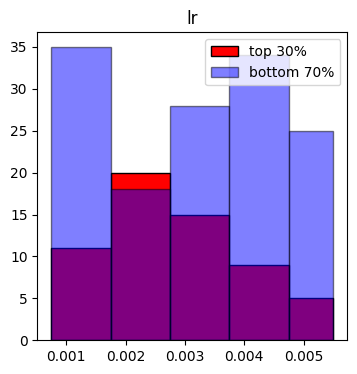

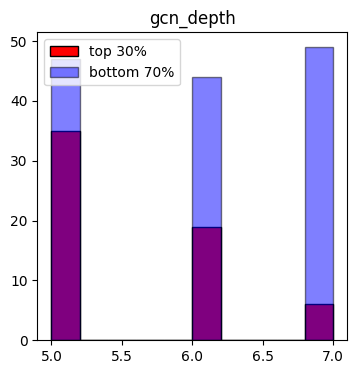

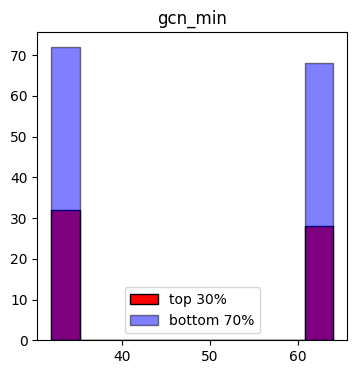

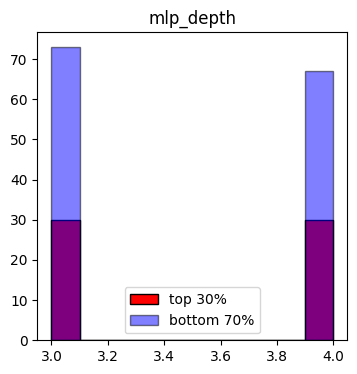

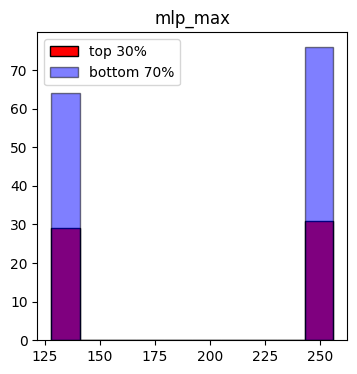

In [5]:
def compare_slice_by_column(df, column, slice_by, percentile=0.5):
    best_half = df[df[slice_by] > df[slice_by].quantile(percentile)]
    worst_half = df[df[slice_by] <= df[slice_by].quantile(percentile)]
    fig, ax = plt.subplots(figsize=(4, 4))
    best = best_half[column]
    worst = worst_half[column]
    if column == 'lr':
        # manually bin based on unique values of lr, in log axis
        # best = np.log10(best)
        # worst = np.log10(worst)
        # bins = np.log10(np.unique(df[column]))
        bins = np.unique(df[column])
        bins = np.concatenate((bins, [bins[-1] + 0.0005])) - 0.00025
        bins[-1] += 0.00025
        # print(np.log10(np.unique(df[column])))
        # print(bins)
    else:
        bins = 10
    cts, bins, _ = ax.hist(best, bins=bins, alpha=1, color='r', label='top {}%'.format(100 - int(percentile * 100)), edgecolor='black')
    ax.hist(worst, bins=bins, alpha=0.5, color='b', label='bottom {}%'.format(int(percentile * 100)), edgecolor='black')
    ax.legend()
    ax.set_title(column)

for column in ['lr', 'gcn_depth', 'gcn_min', 'mlp_depth', 'mlp_max']:
    compare_slice_by_column(df[df['lr'] >= 0.001], column, 'val_acc', percentile=0.7)

In [11]:
for column in ['lr', 'gcn_depth', 'gcn_min', 'mlp_depth', 'mlp_max']:
    print(column, df[column].unique())

lr [0.003 0.002 0.001 0.004 0.005]
gcn_depth [6 7 5]
gcn_min [32 64]
mlp_depth [4 3]
mlp_max [256 128]


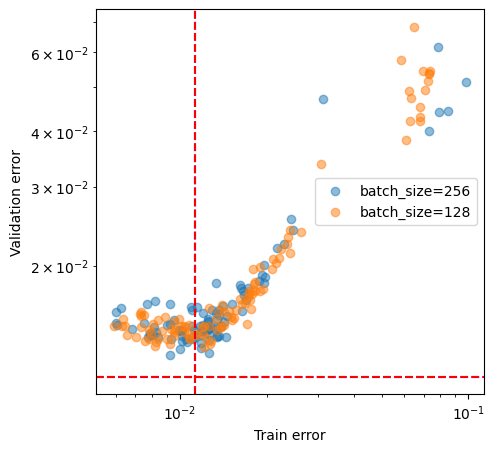

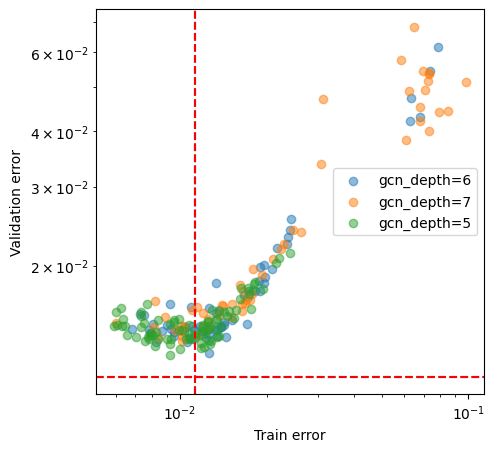

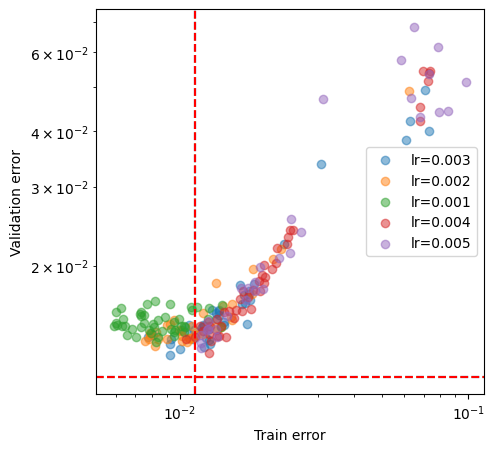

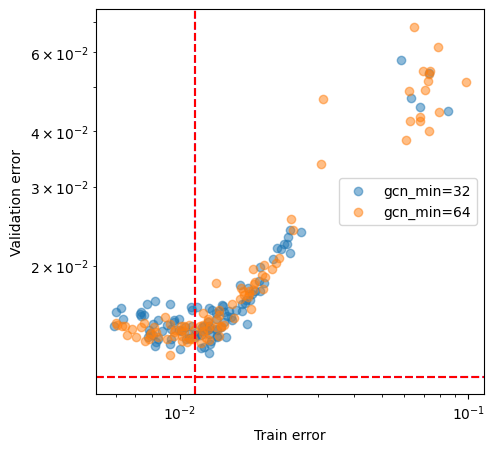

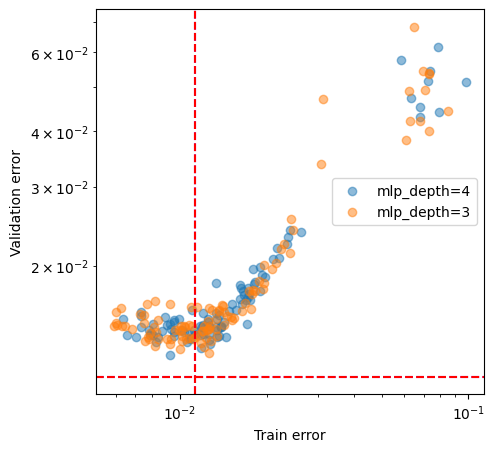

In [27]:
# mwpm_err = 8e-4 # p=0.001
mwpm_err = 0.0113 # p=0.004
plt.close('all')
def plot_by_variables(df, col_name):
    """Plot the validation error vs train error in different colors for each unique value of col_name."""
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df[col_name].unique())))
    fig, ax = plt.subplots(figsize=(5, 5))
    for col_val, color in zip(df[col_name].unique(), colors):
        half = df[df[col_name] == col_val]
        x = 1- half["train_acc"]
        y = 1 - half["val_acc"]
        ax.scatter(x, y, alpha=0.5, label=f"{col_name}={col_val}")
        ax.set_xlabel("Train error")
        ax.set_ylabel("Validation error")
        ax.axhline(mwpm_err, ls='--', c=color)
        ax.axvline(mwpm_err, ls='--', c=color)
        ax.loglog()
        ax.legend()

plot_by_variables(df, 'batch_size')
plot_by_variables(df, 'gcn_depth')
plot_by_variables(df, 'lr')
plot_by_variables(df, 'gcn_min')
plot_by_variables(df, 'mlp_depth')
